In [1]:
!pip install tifffile


In [2]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd

C:\Users\prana\Desktop\CV_Project
Data shape: (1065, 1536, 2048)
Data type: uint8
Min and max values: 1, 255


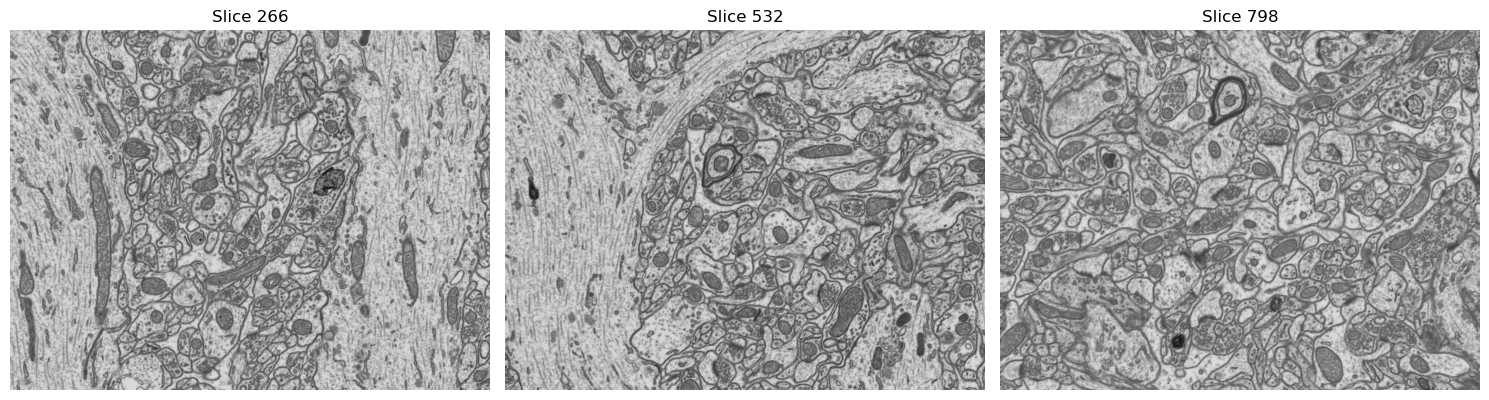

In [7]:

# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

# Load the .tif file
data = tiff.imread(current_directory + "\\volumedata.tif" )

print(f"Data shape: {data.shape}")
print(f"Data type: {data.dtype}")
print(f"Min and max values: {data.min()}, {data.max()}")

# Visualize some slices from the 3D stack
num_slices = data.shape[0]
sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]  # you can modify these or add more indices

fig, axes = plt.subplots(1, len(sample_slices), figsize=(15,5))
for idx, slice_idx in enumerate(sample_slices):
    axes[idx].imshow(data[slice_idx, ...], cmap='gray')
    axes[idx].set_title(f'Slice {slice_idx}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Training Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 22, 244



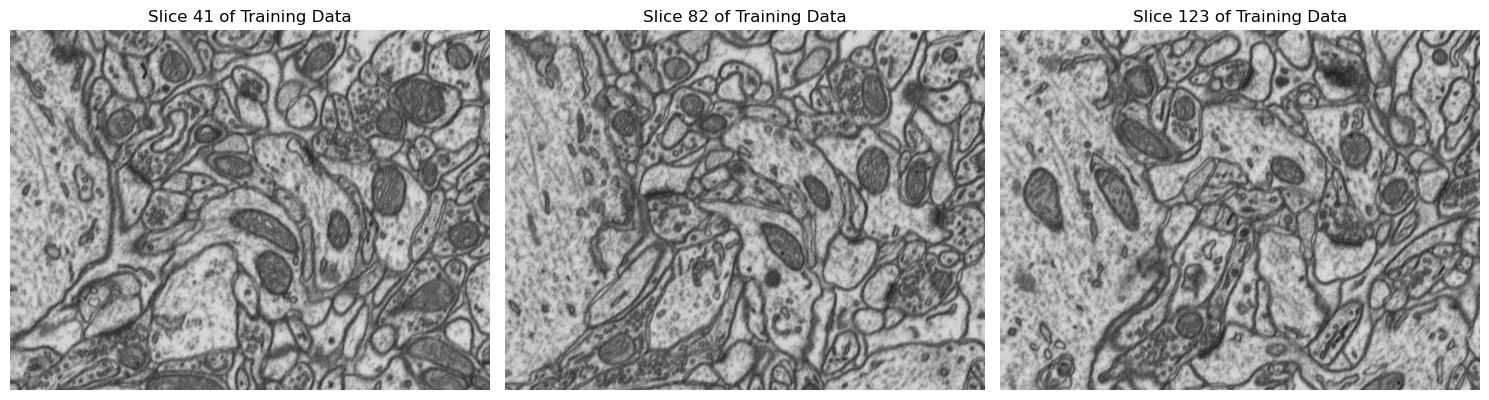

Training Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



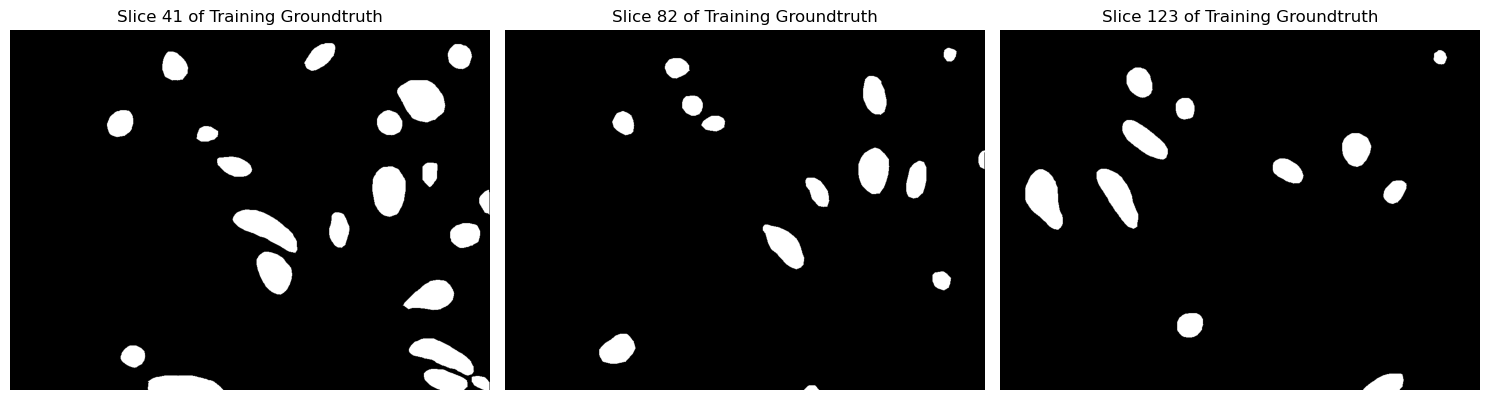

Testing Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 2, 255



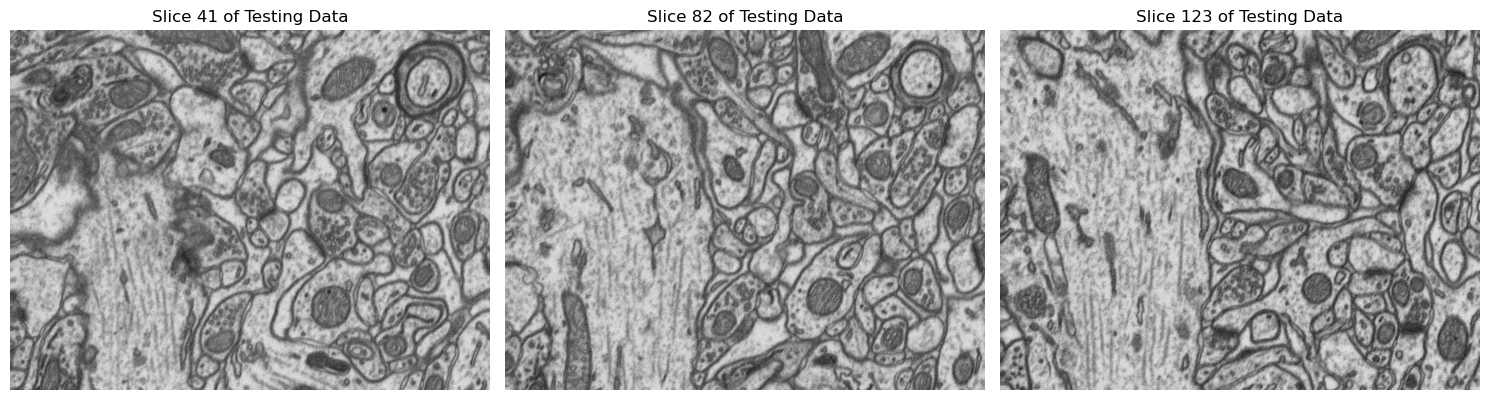

Testing Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



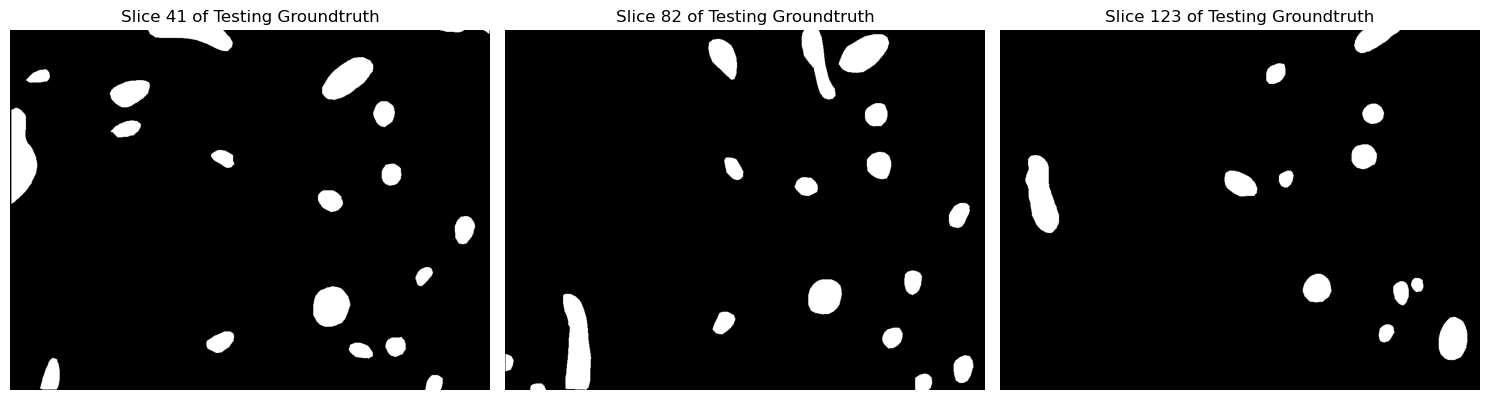

In [8]:
# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\" # replace with the path to your directory

# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

datasets = {
    "Training Data": train_data,
    "Training Groundtruth": train_groundtruth,
    "Testing Data": test_data,
    "Testing Groundtruth": test_groundtruth
}

# Exploring and visualizing the datasets
for name, data in datasets.items():
    print(f"{name}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min and max values: {data.min()}, {data.max()}\n")

    # Visualize some slices
    num_slices = data.shape[0]
    sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]

    fig, axes = plt.subplots(1, len(sample_slices), figsize=(15, 5))
    for idx, slice_idx in enumerate(sample_slices):
        axes[idx].imshow(data[slice_idx, ...], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx} of {name}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_3d_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Contracting Path
    c1 = layers.Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    c2 = layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    
    c3 = layers.Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.1)(c3)
    p3 = layers.MaxPooling3D((2, 2, 1))(c3)
    
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.1)(c4)
    
    # Expanding Path
    u1 = layers.Conv3DTranspose(64, (2, 2, 1), strides=(2, 2, 1), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u1)
    c5 = layers.Dropout(0.1)(c5)

    u2 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u2)
    c6 = layers.Dropout(0.1)(c6)

    u3 = layers.Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u3)
    c7 = layers.Dropout(0.1)(c7)
    
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c7)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [24]:
from scipy.ndimage import zoom

def resize_volume(volume, shape):
    factors = [s/v for s, v in zip(shape, volume.shape)]
    return zoom(volume, factors, mode='nearest')

# Desired new shape
new_shape = (768, 1024, 128)

# Resizing each dataset
for dataset_name, data in datasets.items():
    datasets[dataset_name] = resize_volume(data, new_shape)

# Referencing the resized data for further operations
resized_train_data = datasets["Training Data"]
resized_train_groundtruth = datasets["Training Groundtruth"]
resized_test_data = datasets["Testing Data"]
resized_test_groundtruth = datasets["Testing Groundtruth"]


In [27]:
# Based on your data shape, the images are of size (165, 768, 1024) and have a single channel.
# But note: 165 might be the number of slices/volumes. So, consider a shape like (768, 1024, 165, 1) for a single volume.
model = create_3d_unet((768, 1024, 128, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 768, 1024, 128, 1)
(None, 768, 1024, 128, 1)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 768, 1024, 128, 1)   0         []                            
                             ]                                                                    
                                                                                                  
 conv3d_50 (Conv3D)          (None, 768, 1024, 128, 16)   448       ['input_10[0][0]']            
                                                                                                  
 dropout_46 (Dropout)        (None, 768, 1024, 128, 16)   0         ['conv3d_50[0][0]']           
                                                                                                  
 max_pooling3d_21 (MaxPooli  (None, 384,

In [30]:
# Reshape data to add the channel dimension
train_data = resized_train_data.reshape((-1, 768, 1024, 128, 1))
train_groundtruth = resized_train_groundtruth.reshape((-1, 768, 1024, 128, 1))
test_data = resized_test_data.reshape((-1, 768, 1024, 128, 1))
test_groundtruth = resized_test_groundtruth.reshape((-1, 768, 1024, 128, 1))

# Normalize data to the range [0, 1]
train_data = train_data / 255.0
test_data = test_data / 255.0

In [ ]:
# Note: This will require a significant amount of memory and computational power. 
# Adjust batch_size and epochs based on your machine's capabilities.
history = model.fit(train_data, train_groundtruth, batch_size=2, epochs=10, validation_data=(test_data, test_groundtruth))


Epoch 1/10


****LOAD DATA HERE****

In [3]:
import os
import numpy as np
import tifffile as tiff
from skimage.transform import resize

# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\"

# Load resized images from folders
def load_resized_data(data_dir, filename):
    data = np.zeros((165, 128, 128), dtype=np.uint8)
    for i in range(165):
        data[i] = tiff.imread(os.path.join(data_dir, f'{os.path.basename(filename)}_{i}.tif'))
    return data

print(directory)

resized_train_data = load_resized_data(directory + "reTrain", "train")
resized_train_groundtruth = load_resized_data(directory + "reTrainGT", "train_gt" )
resized_test_data = load_resized_data(directory + "reTest", "test")
resized_test_groundtruth = load_resized_data(directory + "reTestGT", "test_gt")


C:\Users\prana\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


C:\Users\prana\Desktop\CV_Project\tif\


In [25]:

# Reshape data to add the channel dimension
train_data = resized_train_data.reshape(165, 128, 128, 1)  # Add channel dimension
train_groundtruth = resized_train_groundtruth.reshape(165, 128, 128, 1)  # Add channel dimension
test_data = resized_test_data.reshape(165, 128, 128, 1)  # Add channel dimension
test_groundtruth = resized_test_groundtruth.reshape(165, 128, 128, 1)  # Add channel dimension

# Normalize data to the range [0, 1]
train_data = train_data / 255.0
test_data = test_data / 255.0

In [81]:
import keras.backend as K
!pip install tensorflow-addons
import tensorflow_addons as tfa

import tensorflow as tf


def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    x = intersection / (union + 1e-6)
    return x


# F1 score (also known as Dice in the context of image segmentation)
def f1_score(y_true, y_pred):
    return dice_coef(y_true, y_pred)


In [58]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Add,Dropout,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

from tensorflow.keras.layers import Activation

def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Contracting path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)
    
    c5 = conv_block(p4, 1024)
    
    # Expanding path
    u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u1 = concatenate([u1, c4])
    u1 = Dropout(0.2)(u1)
    c6 = conv_block(u1, 512)
    
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u2 = concatenate([u2, c3])
    u2 = Dropout(0.2)(u2)
    c7 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u3 = concatenate([u3, c2])
    u3 = Dropout(0.1)(u3)
    c8 = conv_block(u3, 128)
    
    u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u4 = concatenate([u4, c1])
    u4 = Dropout(0.1)(u4)
    c9 = conv_block(u4, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return Model(inputs=inputs, outputs=outputs)

model = unet_model()

In [84]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='unet_best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [reduce_lr, early_stopping, model_checkpoint]


In [85]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])


history = model.fit(
    train_data, train_groundtruth,
    epochs=50,
    validation_data=(test_data, test_groundtruth),
    batch_size=8,
    callbacks=callbacks
)

Epoch 1/50
21/21 [==============================] - 69s 3s/step - loss: -463.2516 - accuracy: 0.8631 - dice_coefficient: 1.9548 - iou: 46.1987 - val_loss: 11.7337 - val_accuracy: 0.7207 - val_dice_coefficient: 0.4245 - val_iou: 0.2712 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 60s 3s/step - loss: -531.2621 - accuracy: 0.8857 - dice_coefficient: 1.9668 - iou: 59.9260 - val_loss: 26.9974 - val_accuracy: 0.9102 - val_dice_coefficient: 0.2466 - val_iou: 0.1407 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 60s 3s/step - loss: -593.6083 - accuracy: 0.8954 - dice_coefficient: 1.9715 - iou: 69.5348 - val_loss: 34.4356 - val_accuracy: 0.9140 - val_dice_coefficient: 0.1458 - val_iou: 0.0786 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 60s 3s/step - loss: -654.7037 - accuracy: 0.8970 - dice_coefficient: 1.9743 - iou: 77.6687 - val_loss: 41.5230 - val_accuracy: 0.9144 - val_dice_coefficient: 0.0886 - val_iou: 0.0463 - lr: 0.0010
Epoch 5/

In [79]:
model.save(directory + "tifUNET.hdf5")

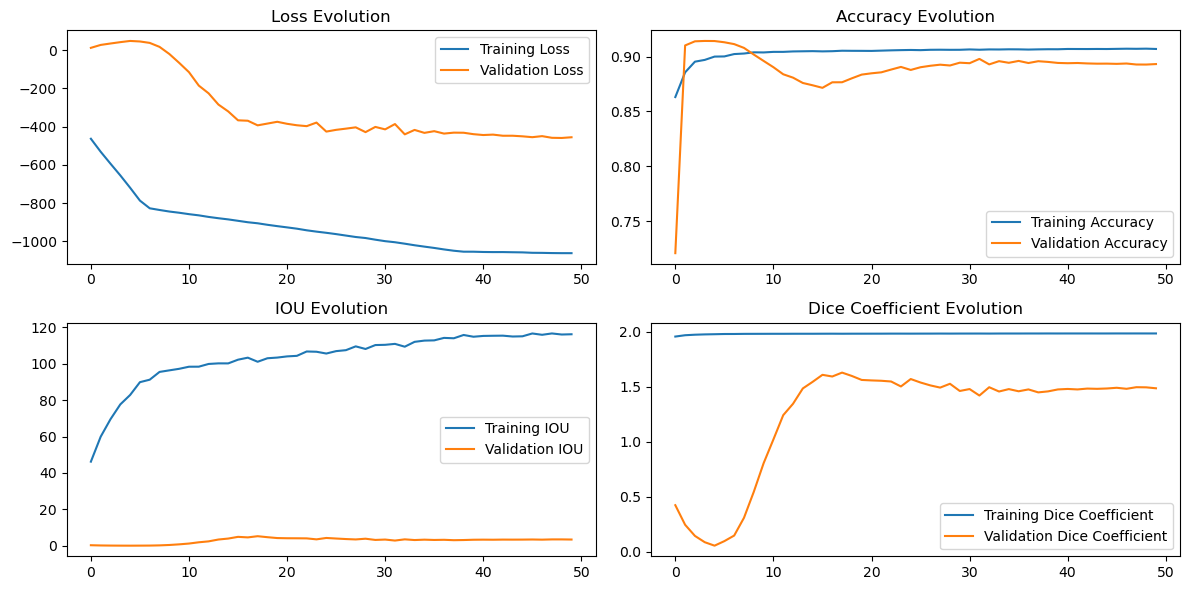

In [86]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting training & validation accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Plotting training & validation IOU
plt.subplot(2, 2, 3)
plt.plot(history.history['iou'], label='Training IOU')
plt.plot(history.history['val_iou'], label='Validation IOU')
plt.legend()
plt.title('IOU Evolution')

# Plotting training & validation Dice coefficient
plt.subplot(2, 2, 4)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient Evolution')



plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 119ms/step


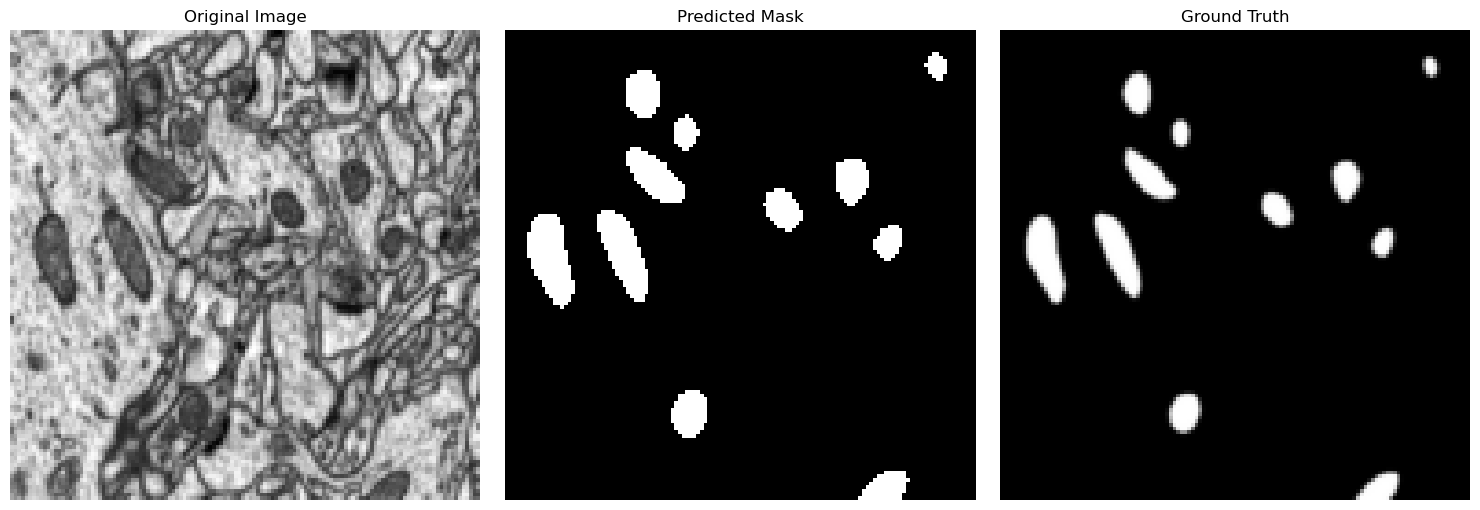

1/1 [==============================] - 0s 119ms/step


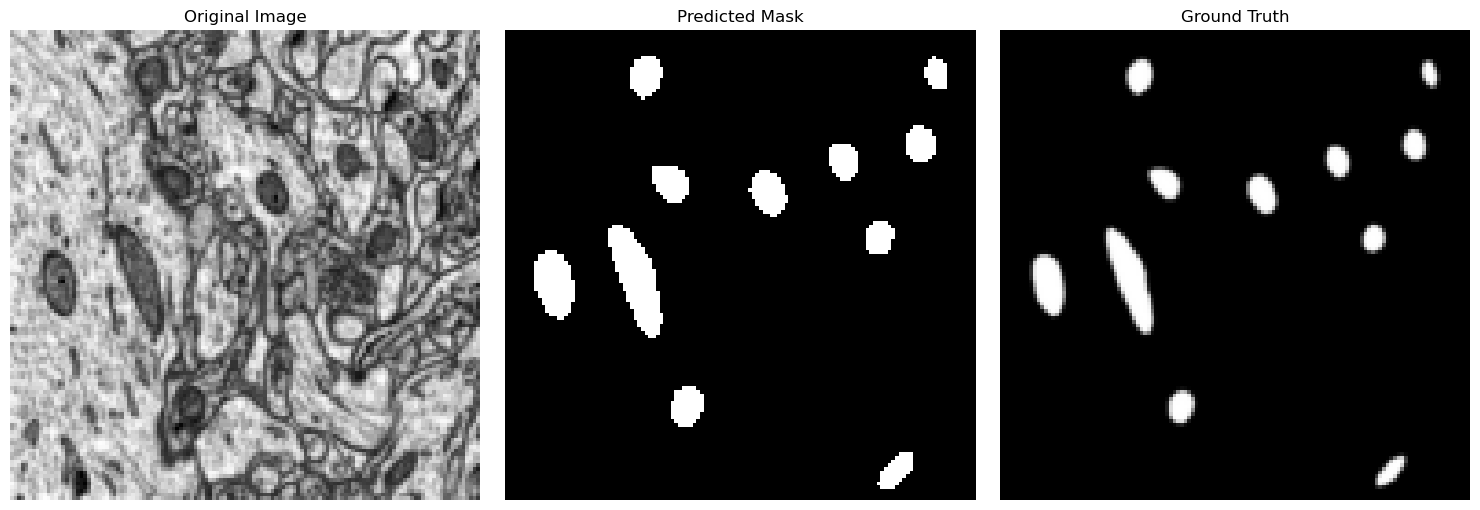

1/1 [==============================] - 0s 128ms/step


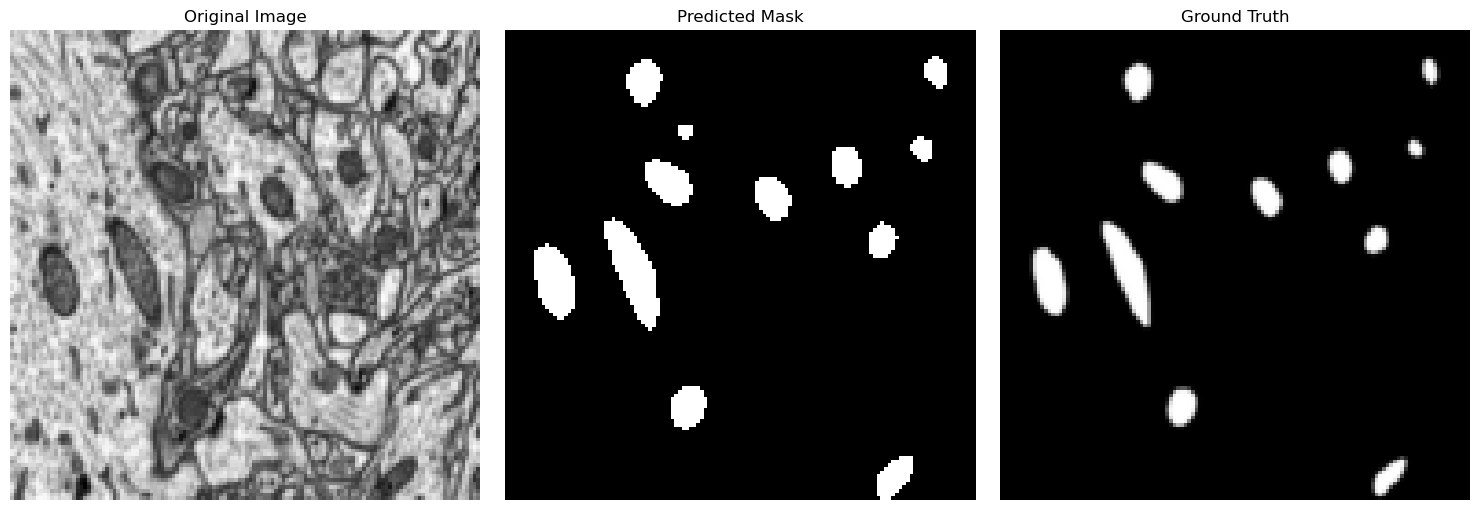

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Randomly pick 2-3 indices from the sample images
num_samples_to_show = random.choice([2, 3])
random_indices = random.sample(range(len(train_data)), 3)

for idx in random_indices:
    # Predicting on the sample image
    sample = np.expand_dims(train_data[idx], axis=0)  # Add batch dimension
    predicted_mask = model.predict(sample)
    predicted_mask = np.squeeze(predicted_mask, axis=(0, -1))  # Removing batch and channel dimensions

    # Threshold the prediction to get binary mask
    threshold = 0.6
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(train_data[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 3, 3)
    plt.imshow(train_groundtruth[idx], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
